This example shows a deformation-dependent TL formulation based on 20-node brick elements. A beam is under pure bending, and the non-symmetric contribution to the stiffness matrix by the deformation-dependent force is ignored, given that the load is reasonably small. Only the load term is updated in equilibrium iterations.


Outer iteration 1, Inner iterations 1, Residual norm: 4.167e-02, del_U norm: 4.425e+00, Condition number: 8.463e+10
Outer iteration 1, Inner iterations 2, Residual norm: 2.710e+01, del_U norm: 2.144e-02, Condition number: 9.948e+09
Outer iteration 1, Inner iterations 3, Residual norm: 4.068e-03, del_U norm: 4.009e-02, Condition number: 8.403e+10
Outer iteration 1, Inner iterations 4, Residual norm: 1.925e-03, del_U norm: 1.977e-04, Condition number: 8.416e+10
Outer iteration 1, Inner iterations 5, Residual norm: 5.220e-07, del_U norm: 1.985e-05, Condition number: 8.431e+10
Outer iteration 1, Inner iterations 6, Residual norm: 4.451e-08, del_U norm: 2.335e-07, Condition number: 8.431e+10
Outer iteration 1, Inner iterations 7, Residual norm: 5.876e-10, del_U norm: 9.588e-09, Condition number: 8.431e+10
Outer iteration 1, Inner iterations 8, Residual norm: 6.208e-11, del_U norm: 1.736e-10, Condition number: 8.431e+10
Outer iteration 2, Inner iterations 1, Residual norm: 4.388e-02, del_U 

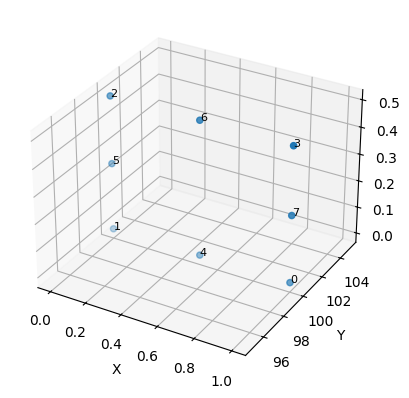

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import meshio
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve
from scipy.sparse.linalg import eigsh
from scipy.sparse import dok_matrix


# ====================== Element Class ======================
class Element20node3D:  
    def H(self, r, s, t):        
        return self.quadraticElements(r, s, t)
        
    def dhdR(self, r, s, t):
        # dh/dr
        dhdr = np.array([
            (s - 1)*(t - 1)*(2*r + s + t + 1)/8,
            -(s - 1)*(t - 1)*(-2*r + s + t + 1)/8,
            -(s + 1)*(t - 1)*(2*r + s - t - 1)/8,
            -(s + 1)*(t - 1)*(2*r - s + t + 1)/8,
            -(s - 1)*(t + 1)*(2*r + s - t + 1)/8,
            -(s - 1)*(t + 1)*(2*r - s + t - 1)/8,
            (s + 1)*(t + 1)*(2*r + s + t - 1)/8,
            (s + 1)*(t + 1)*(2*r - s - t + 1)/8,
            -r*(s - 1)*(t - 1)/2,
            (s**2 - 1)*(t - 1)/4,
            r*(s + 1)*(t - 1)/2,
            -(s**2 - 1)*(t - 1)/4,
            r*(s - 1)*(t + 1)/2,
            -(s**2 - 1)*(t + 1)/4,
            -r*(s + 1)*(t + 1)/2,
            (s**2 - 1)*(t + 1)/4,
            -(s - 1)*(t**2 - 1)/4,
            (s - 1)*(t**2 - 1)/4,
            -(s + 1)*(t**2 - 1)/4,
            (s + 1)*(t**2 - 1)/4
            ])

        # dh/ds
        dhds = np.array([
            (r - 1)*(t - 1)*(r + 2*s + t + 1)/8,
            -(r + 1)*(t - 1)*(-r + 2*s + t + 1)/8,
            -(r + 1)*(t - 1)*(r + 2*s - t - 1)/8,
            -(r - 1)*(t - 1)*(r - 2*s + t + 1)/8,
            -(r - 1)*(t + 1)*(r + 2*s - t + 1)/8,
            -(r + 1)*(t + 1)*(r - 2*s + t - 1)/8,
            (r + 1)*(t + 1)*(r + 2*s + t - 1)/8,
            (r - 1)*(t + 1)*(r - 2*s - t + 1)/8,
            -(r**2 - 1)*(t - 1)/4,
            s*(r + 1)*(t - 1)/2,
            (r**2 - 1)*(t - 1)/4,
            -s*(r - 1)*(t - 1)/2,
            (r**2 - 1)*(t + 1)/4,
            -s*(r + 1)*(t + 1)/2,
            -(r**2 - 1)*(t + 1)/4,
            s*(r - 1)*(t + 1)/2,
            -(r - 1)*(t**2 - 1)/4,
            (r + 1)*(t**2 - 1)/4,
            -(r + 1)*(t**2 - 1)/4,
            (r - 1)*(t**2 - 1)/4
            ])
        
        # dh/dt
        dhdt = np.array([
            (r - 1)*(s - 1)*(r + s + 2*t + 1)/8,
            -(r + 1)*(s - 1)*(-r + s + 2*t + 1)/8,
            -(r + 1)*(s + 1)*(r + s - 2*t - 1)/8,
            -(r - 1)*(s + 1)*(r - s + 2*t + 1)/8,
            -(r - 1)*(s - 1)*(r + s - 2*t + 1)/8,
            -(r + 1)*(s - 1)*(r - s + 2*t - 1)/8,
            (r + 1)*(s + 1)*(r + s + 2*t - 1)/8,
            (r - 1)*(s + 1)*(r - s - 2*t + 1)/8,
            -(r**2 - 1)*(s - 1)/4,
            (r + 1)*(s**2 - 1)/4,
            (r**2 - 1)*(s + 1)/4,
            -(r - 1)*(s**2 - 1)/4,
            (r**2 - 1)*(s - 1)/4,
            -(r + 1)*(s**2 - 1)/4,
            -(r**2 - 1)*(s + 1)/4,
            (r - 1)*(s**2 - 1)/4,
            -t*(r - 1)*(s - 1)/2,
            t*(r + 1)*(s - 1)/2,
            -t*(r + 1)*(s + 1)/2,
            t*(r - 1)*(s + 1)/2
        ])

        return np.array([dhdr, dhds, dhdt])

    def quadraticElements(self,r, s, t):
        return np.array([
            (1 - r) * (1 - s) * (1 - t) * (-r - s - t -2) /8,
            (1 + r) * (1 - s) * (1 - t) * (r - s - t - 2) /8,
            (1 + r) * (1 + s) * (1 - t) * (r + s - t - 2) /8,
            (1 - r) * (1 + s) * (1 - t) * (-r + s - t - 2) /8,
            (1 - r) * (1 - s) * (1 + t) * (-r - s + t - 2) /8,
            (1 + r) * (1 - s) * (1 + t) * (r - s + t - 2) /8,
            (1 + r) * (1 + s) * (1 + t) * (r + s + t - 2) /8,
            (1 - r) * (1 + s) * (1 + t) * (-r + s + t - 2) /8,
            (1 - r**2) * (1 - s) * (1 - t) /4,
            (1 - s**2) * (1 + r) * (1 - t) /4,
            (1 - r**2) * (1 + s) * (1 - t) /4,
            (1 - s**2) * (1 - r) * (1 - t) /4,
            (1 - r**2) * (1 - s) * (1 + t) /4,
            (1 - s**2) * (1 + r) * (1 + t) /4,
            (1 - r**2) * (1 + s) * (1 + t) /4,
            (1 - s**2) * (1 - r) * (1 + t) /4,
            (1 - t**2) * (1 - r) * (1 - s) /4,
            (1 - t**2) * (1 + r) * (1 - s) /4,
            (1 - t**2) * (1 + r) * (1 + s) /4,
            (1 - t**2) * (1 - r) * (1 + s) /4
        ])
    
    def quadraticFace(self, r, s):
        return np.array([
            -(1 - r) * (1 - s) * (1 + r + s) /4,
            -(1 + r) * (1 - s) * (1 - r + s) /4,
            -(1 + r) * (1 + s) * (1 - r - s) /4,
            -(1 - r) * (1 + s) * (1 + r - s) /4,
            (1 - r**2) * (1 - s) /2,
            (1 + r) * (1 - s**2) /2,
            (1 - r**2) * (1 + s) /2,
            (1 - r) * (1 - s**2) /2
        ])

# ====================== Problem Setup ======================
element_model = Element20node3D()
mesh = meshio.read("BeamUnderBendingExample.msh")
nodes = mesh.points
elements = mesh.cells_dict["hexahedron20"]
faces_BC = mesh.cells_dict["quad8"]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # Get the coordinates of the nodes for the first element
# coords = nodes[faces_BC[0,:], :]
# ax.scatter(coords[:,0], coords[:,1], coords[:,2])
# # label each point with its index
# for i, (x, y, z) in enumerate(coords):
#     ax.text(x, y, z, str(i), fontsize=8)
# ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

# Set up the material properties
E, nu = 12000, 0.0 
C = E / (1 - 2 * nu) / (1 + nu) * np.array([[1 - nu, nu, nu, 0, 0 ,0], 
                                            [nu, 1 - nu, nu, 0, 0, 0], 
                                            [nu, nu, 1 - nu, 0 ,0 ,0], 
                                            [0, 0, 0, (1 - 2 * nu) / 2, 0, 0], 
                                            [0, 0, 0, 0, (1 - 2 * nu) / 2, 0], 
                                            [0, 0, 0, 0, 0, (1 - 2 * nu) / 2]])

P = 0.5 # load step

GQ_K_x, GQ_K_w = np.polynomial.legendre.leggauss(4)

numN = nodes.shape[0]
numE = elements.shape[0]
ndofs_per_dimension = numN
total_dofs = 3 * ndofs_per_dimension



# ====================== Boundary Conditions ======================
# Step 1: Find nodes on the bottom edge (y == 0)
BC_fix_xdir = np.where(np.abs(nodes[:, 1]) < 1e-6)[0]
# Step 2: Y-direction constraints (offset by ndofs_per_dimension)
BC_fix_ydir = BC_fix_xdir + ndofs_per_dimension
# Step 3: Z-direction constraints (offset by 2 * ndofs_per_dimension)
BC_fix_zdir = BC_fix_xdir + 2 * ndofs_per_dimension
# Step 4: Combine and sort unique constraints
BC_constrained = np.unique(np.concatenate([BC_fix_xdir, BC_fix_ydir, BC_fix_zdir]))
# Step 4: Get free DOFs
BC_free = np.setdiff1d(np.arange(0, total_dofs), BC_constrained)


# Search elements that contain Neumann nodes
# Append pair of (elem, f_BC) and its corresponding elements
elements_natural = []
for face in faces_BC:
    for elem in elements:
        if np.all(np.isin(face, elem)):
            elements_natural.append((elem, face)) 
    

# ====================== Newton-Rhapson Iterations ======================
U = np.zeros((total_dofs,1))
Uz = []
Ux = []
Uy = []
for outer_iter, force_factor in enumerate(np.arange(1,11,1)):

    

    for inner_iter in range(100):
        
        #--------------------------------------------------------------#
        #-------Load upate depending on the current displacement-------#
        #--------------------------------------------------------------#

        # Boundary condition: Apply bending moment at the tip
        R  = np.zeros((total_dofs, 1))
        nodes_updated = nodes + U.reshape(-1, 3, order='F')
            
        
        # Identify the natural coordinates of the face nodes
        # Assuming all faces are quadrilateral with 8 nodes
        # Loop over each face with Neumann BC
        for elem, face in elements_natural:
            # If face[0] - face[3] are in the indices of 0, 1, 2 ,3, then it is the face with t = -1
            # If face[0] - face[3] are in the indices of 4, 5, 6 ,7, then it is the face with t = +1    
            # If face[0] - face[3] are in the indices of 0, 1, 5 ,4, then it is the face with s = -1
            # If face[0] - face[3] are in the indices of 3 ,2, 6 ,7, then it is the face with s = +1
            # If face[0] - face[3] are in the indices of 0, 3, 7 ,4, then it is the face with r = -1
            # If face[0] - face[3] are in the indices of 1, 2, 6 ,5, then it is the face with r = +1
            if np.all(np.isin(face[0:4], elem[0:4])):
                # Face with t = -1
                t_surf = -1
            elif np.all(np.isin(face[0:4], elem[4:8])):
                # Face with t = +1
                t_surf = 1
            elif np.all(np.isin(face[0:4], [elem[0], elem[1], elem[5], elem[4]])):
                # Face with s = -1
                s_surf = -1
            elif np.all(np.isin(face[0:4], [elem[3], elem[2], elem[6], elem[7]])):
                # Face with s = +1
                s_surf = 1
            elif np.all(np.isin(face[0:4], [elem[0], elem[3], elem[7], elem[4]])):
                # Face with r = -1
                r_surf = -1
            elif np.all(np.isin(face[0:4], [elem[1], elem[2], elem[6], elem[5]])):
                # Face with r = +1
                r_surf = 1
            else:
                # throw exception
                raise ValueError("Face nodes do not match any face of the element.")
            
            phi = np.array(elem)

            for i, zeta in enumerate(GQ_K_x):
                for j, eta in enumerate(GQ_K_x):
                    # Shape functions at (zeta, eta)
                    if 't_surf' in locals():
                        # Face with constant t
                        H = element_model.quadraticElements(zeta, eta, t_surf)
                        # Jacobian for the face
                        J = element_model.dhdR(zeta, eta, t_surf) @ nodes_updated[elem, :]
                        # Normal vector
                        normal_vec = np.cross(J[:, 0], J[:, 1])
                        det_J_face = np.linalg.norm(normal_vec)
                        normal_vec = normal_vec / det_J_face

                        HrHsHt = element_model.dhdR(zeta, eta, t_surf)  # Shape: (3, 60)
                        HxHyHz = np.linalg.solve(J, HrHsHt)   # Shape: (3, 60)
                        Hx, Hy, Hz = HxHyHz[0], HxHyHz[1], HxHyHz[2] # Extract rows
                        Hx = Hx.reshape(1, -1)
                        Hy = Hy.reshape(1, -1)
                        Hz = Hz.reshape(1, -1)
                    elif 's_surf' in locals():
                        # Face with constant s
                        H = element_model.quadraticElements(zeta, s_surf, eta)
                        # Jacobian for the face
                        J = element_model.dhdR(zeta, s_surf, eta) @ nodes_updated[elem, :]
                        # Normal vector
                        normal_vec = np.cross(J[:, 2], J[:, 0])
                        det_J_face = np.linalg.norm(normal_vec)
                        normal_vec = normal_vec / det_J_face

                        HrHsHt = element_model.dhdR(zeta, s_surf, eta)  # Shape: (3, 60)
                        HxHyHz = np.linalg.solve(J, HrHsHt)   # Shape: (3, 60)
                        Hx, Hy, Hz = HxHyHz[0], HxHyHz[1], HxHyHz[2] # Extract rows
                        Hx = Hx.reshape(1, -1)
                        Hy = Hy.reshape(1, -1)
                        Hz = Hz.reshape(1, -1)
                    elif 'r_surf' in locals():
                        # Face with constant r
                        H = element_model.quadraticElements(r_surf, zeta, eta)
                        # Jacobian for the face
                        J = element_model.dhdR(r_surf, zeta, eta) @ nodes_updated[elem, :]
                        # Normal vector
                        normal_vec = np.cross(J[:, 1], J[:, 2])
                        det_J_face = np.linalg.norm(normal_vec)
                        normal_vec = normal_vec / det_J_face

                        HrHsHt = element_model.dhdR(r_surf, zeta, eta)  # Shape: (3, 60)
                        HxHyHz = np.linalg.solve(J, HrHsHt)   # Shape: (3, 60)
                        Hx, Hy, Hz = HxHyHz[0], HxHyHz[1], HxHyHz[2] # Extract rows
                        Hx = Hx.reshape(1, -1)
                        Hy = Hy.reshape(1, -1)
                        Hz = Hz.reshape(1, -1)
                    else:
                        raise ValueError("Surface face not defined properly.")
                    
                    # For this example, we apply a bending moment around the x-axis at the tip
                    # and the tip corresponds to s = 1 face
                    normal_vec_bending = normal_vec * (-eta)

                    # X = np.array([[Hx @ U[phi], Hy @ U[phi], Hz @ U[phi]],
                    #                 [Hx @ U[phi + ndofs_per_dimension], Hy @ U[phi + ndofs_per_dimension], Hz @ U[phi + ndofs_per_dimension]],
                    #                 [Hx @ U[phi + 2 * ndofs_per_dimension], Hy @ U[phi + 2 * ndofs_per_dimension], Hz @ U[phi + 2 * ndofs_per_dimension]]])
                    # X = X + np.eye(3)
                    # normal_vec_bending = np.linalg.solve(X, normal_vec_bending)
                    
                    fx = H * det_J_face * GQ_K_w[i] * GQ_K_w[j] * normal_vec_bending[0]
                    fy = H * det_J_face * GQ_K_w[i] * GQ_K_w[j] * normal_vec_bending[1]
                    fz = H * det_J_face * GQ_K_w[i] * GQ_K_w[j] * normal_vec_bending[2]
                    
                    R[elem] += force_factor * P * fx.reshape(-1,1)
                    R[elem + ndofs_per_dimension] += force_factor * P * fy.reshape(-1,1)
                    R[elem + 2 * ndofs_per_dimension] += force_factor * P * fz.reshape(-1,1)


        #-----------------------------------------------------------------------#
        #-------Stiffness matrix update depending on current displacement-------#
        #-----------------------------------------------------------------------#

        row_idx, col_idx, data_val_K, data_val_M = [], [], [], []
        F = np.zeros((total_dofs, 1))
        for elem_node_indices in elements:
            phi = np.array(elem_node_indices)
            
            Ke = np.zeros((60, 60))
            Fe = np.zeros((60, 1))

            # ----- Stiffness Matrix Integration -----
            for i, r in enumerate(GQ_K_x):
                for j, s in enumerate(GQ_K_x):
                    for k, t in enumerate(GQ_K_x):

                        J = element_model.dhdR(r, s, t) @ nodes[elem_node_indices, :3]
                        HrHsHt = element_model.dhdR(r, s, t)  # Shape: (3, 60)
                        HxHyHz = np.linalg.solve(J, HrHsHt)   # Shape: (3, 60)
                        Hx, Hy, Hz = HxHyHz[0], HxHyHz[1], HxHyHz[2] # Extract rows
                        Hx = Hx.reshape(1, -1)
                        Hy = Hy.reshape(1, -1)
                        Hz = Hz.reshape(1, -1)

                        # G-L strain and 2nd Piola-Kirchhoff stress
                        eps11 = Hx @ U[phi] + 0.5 * (Hx @ U[phi])**2 + 0.5 * (Hx @ U[phi + ndofs_per_dimension])**2 + 0.5 * (Hx @ U[phi + 2 * ndofs_per_dimension])**2
                        eps22 = Hy @ U[phi + ndofs_per_dimension] + 0.5 * (Hy @ U[phi])**2 + 0.5 * (Hy @ U[phi + ndofs_per_dimension])**2 + + 0.5 * (Hy @ U[phi + 2 * ndofs_per_dimension])**2
                        eps33 = Hz @ U[phi + 2 * ndofs_per_dimension] + 0.5 * (Hz @ U[phi])**2 + 0.5 * (Hz @ U[phi + ndofs_per_dimension])**2 + 0.5 * (Hz @ U[phi + 2 * ndofs_per_dimension])**2
                        eps12 = 0.5 * ( Hy @ U[phi] 
                                    + Hx @ U[phi + ndofs_per_dimension] 
                                    + Hx @ U[phi] * Hy @ U[phi] 
                                    + Hx @ U[phi + ndofs_per_dimension] * Hy @ U[phi + ndofs_per_dimension]
                                    + Hx @ U[phi + 2 * ndofs_per_dimension] * Hy @ U[phi + 2 * ndofs_per_dimension] )
                        eps23 = 0.5 * ( Hz @ U[phi + ndofs_per_dimension] 
                                    + Hy @ U[phi + 2 * ndofs_per_dimension] 
                                    + Hy @ U[phi] * Hz @ U[phi] 
                                    + Hy @ U[phi + ndofs_per_dimension] * Hz @ U[phi + ndofs_per_dimension]
                                    + Hy @ U[phi + 2 * ndofs_per_dimension] * Hz @ U[phi + 2 * ndofs_per_dimension] )
                        eps31 = 0.5 * ( Hx @ U[phi + 2 * ndofs_per_dimension] 
                                    + Hz @ U[phi] 
                                    + Hz @ U[phi] * Hx @ U[phi] 
                                    + Hz @ U[phi + ndofs_per_dimension] * Hx @ U[phi + ndofs_per_dimension]
                                    + Hz @ U[phi + 2 * ndofs_per_dimension] * Hx @ U[phi + 2 * ndofs_per_dimension] )
                        S = C @ np.concatenate([eps11, eps22, eps33, 2*eps12, 2*eps23, 2*eps31])

                        # K_linear
                        B_L = np.block([
                            [Hx + Hx @ U[phi] * Hx, Hx @ U[phi + ndofs_per_dimension] * Hx, Hx @ U[phi + 2 * ndofs_per_dimension] * Hx],
                            [Hy @ U[phi] * Hy, Hy + Hy @ U[phi + ndofs_per_dimension] * Hy, Hy @ U[phi + 2 * ndofs_per_dimension] * Hy],
                            [Hz @ U[phi] * Hz, Hz @ U[phi + ndofs_per_dimension] * Hz, Hz + Hz @ U[phi + 2 * ndofs_per_dimension] * Hz],
                            [Hy + Hy @ U[phi] * Hx + Hx @ U[phi] * Hy, Hx + Hy @ U[phi + ndofs_per_dimension] * Hx + Hx @ U[phi + ndofs_per_dimension] * Hy, Hy @ U[phi + 2 * ndofs_per_dimension] * Hx + Hx @ U[phi + 2 * ndofs_per_dimension] * Hy],
                            [Hy @ U[phi] * Hz + Hz @ U[phi] * Hy, Hz + Hy @ U[phi + ndofs_per_dimension] * Hz + Hz @ U[phi + ndofs_per_dimension] * Hy, Hy + Hy @ U[phi + 2 * ndofs_per_dimension] * Hz + Hz @ U[phi + 2 * ndofs_per_dimension] * Hy],
                            [Hz + Hz @ U[phi] * Hx + Hx @ U[phi] * Hz, Hz @ U[phi + ndofs_per_dimension] * Hx + Hx @ U[phi + ndofs_per_dimension] * Hz, Hx + Hz @ U[phi + 2 * ndofs_per_dimension] * Hx + Hx @ U[phi + 2 * ndofs_per_dimension] * Hz]
                        ])
                        K_L = B_L.T @ C @ B_L

                        # K_nonlinear
                        K_NL11 = np.block([
                            [Hx.T * S[0] @ Hx, np.zeros((20, 20)), np.zeros((20, 20))],
                            [np.zeros((20, 20)), Hx.T * S[0] @ Hx, np.zeros((20, 20))],
                            [np.zeros((20, 20)), np.zeros((20, 20)), Hx.T * S[0] @ Hx],
                            ])
                        K_NL22 = np.block([
                            [Hy.T * S[1] @ Hy, np.zeros((20, 20)), np.zeros((20, 20))],
                            [np.zeros((20, 20)), Hy.T * S[1] @ Hy, np.zeros((20, 20))],
                            [np.zeros((20, 20)), np.zeros((20, 20)), Hy.T * S[1] @ Hy],
                            ])
                        K_NL33 = np.block([
                            [Hz.T * S[2] @ Hz, np.zeros((20, 20)), np.zeros((20, 20))],
                            [np.zeros((20, 20)), Hz.T * S[2] @ Hz, np.zeros((20, 20))],
                            [np.zeros((20, 20)), np.zeros((20, 20)), Hz.T * S[2] @ Hz],
                            ])
                        K_NL12 = np.block([
                            [Hy.T * S[3] @ Hx + Hx.T * S[3] @ Hy, np.zeros((20, 20)), np.zeros((20, 20))],
                            [np.zeros((20, 20)), Hy.T * S[3] @ Hx + Hx.T * S[3] @ Hy, np.zeros((20, 20))],
                            [np.zeros((20, 20)), np.zeros((20, 20)), Hy.T * S[3] @ Hx + Hx.T * S[3] @ Hy],
                        ])
                        K_NL23 = np.block([
                            [Hz.T * S[4] @ Hy + Hy.T * S[4] @ Hz, np.zeros((20, 20)), np.zeros((20, 20))],
                            [np.zeros((20, 20)), Hz.T * S[4] @ Hy + Hy.T * S[4] @ Hz, np.zeros((20, 20))],
                            [np.zeros((20, 20)), np.zeros((20, 20)), Hz.T * S[4] @ Hy + Hy.T * S[4] @ Hz],
                        ])
                        K_NL31 = np.block([
                            [Hx.T * S[5] @ Hz + Hz.T * S[5] @ Hx, np.zeros((20, 20)), np.zeros((20, 20))],
                            [np.zeros((20, 20)), Hx.T * S[5] @ Hz + Hz.T * S[5] @ Hx, np.zeros((20, 20))],
                            [np.zeros((20, 20)), np.zeros((20, 20)), Hx.T * S[5] @ Hz + Hz.T * S[5] @ Hx],
                        ])
                        
                        K_NL = K_NL11 + K_NL22 + K_NL33 + K_NL12 + K_NL23 + K_NL31
                        
                        if np.linalg.det(J) < 0:
                            print("Determinant of Jacobian is negative, exiting...")
                            exit() # Exits the script
                        Ke += (K_L + K_NL) * np.linalg.det(J) * GQ_K_w[i] * GQ_K_w[j] * GQ_K_w[k]
                        Fe += B_L.T @ S * np.linalg.det(J) * GQ_K_w[i] * GQ_K_w[j] * GQ_K_w[k]

            # ----- Collect Stiffness Matrices -----
            for i in range(60):
                for j in range(60):
                    if i < 20:
                        row = phi[i]
                    elif i < 40:
                        row = phi[i - 20] + ndofs_per_dimension
                    else:
                        row = phi[i - 40] + 2 * ndofs_per_dimension

                    if j < 20:
                        col = phi[j]
                    elif j < 40:
                        col = phi[j - 20] + ndofs_per_dimension
                    else:
                        col = phi[j - 40] + 2 * ndofs_per_dimension

                    row_idx.append(row)
                    col_idx.append(col)
                    data_val_K.append(Ke[i, j])


            F[np.concatenate([phi, phi + ndofs_per_dimension, phi + 2 * ndofs_per_dimension])] += Fe
        
        # ----- Assemble Global Stiffness Matrix -----
        K = coo_matrix((data_val_K, (row_idx, col_idx)), shape=(total_dofs, total_dofs)).tocsr()
        K_ff = K[BC_free[:, None], BC_free]  # shape: (n_free, n_free)
        # Residual vector for free DOFs
        residual = R[BC_free] - F[BC_free]   # shape: (n_free,)
        # Solve for displacement increment
        del_U = spsolve(K_ff, residual).reshape(-1, 1)
        U[BC_free] += del_U
        # Save condition number for each inner iteration
        if outer_iter == 0 and inner_iter == 0:
            cond_Kff_arr = []
        cond_Kff = np.linalg.cond(K_ff.toarray())
        cond_Kff_arr.append(cond_Kff)
        #print(f"Condition number of K_ff: {cond_Kff:.3e}")
        print(f"Outer iteration {outer_iter+1}, Inner iterations {inner_iter+1}, Residual norm: {np.linalg.norm(residual):.3e}, del_U norm: {np.linalg.norm(del_U):.3e}, Condition number: {cond_Kff:.3e}")
        if np.linalg.norm(residual) < 1e-6 and np.linalg.norm(del_U) < 1e-9:            
            break

In [8]:
# ====================== Post-Processing ======================
import pyvista as pv

# Example: elements is a (nElem, 8) array for hex elements
elements_vtk = elements[:,:8]  # Use only the corner nodes for visualization
nodes_deformed = nodes + U.reshape(3, -1).T
nElem, nNodesPerElem = elements_vtk.shape

# VTK cell format requires [nNodesPerElem, nodeId0, nodeId1, ...]
cells = np.hstack([
    np.column_stack([np.full(nElem, nNodesPerElem), elements_vtk])
]).ravel()

# Define cell types: VTK_HEXAHEDRON = 12, VTK_TETRA = 10, VTK_QUAD = 9, etc.
celltypes = np.full(nElem, 12, dtype=np.uint8)  # <-- 12 for hex
# If your elements are tets, use 10

# Build undeformed mesh
grid_undeformed = pv.UnstructuredGrid(cells, celltypes, nodes)

# Build deformed mesh
grid_deformed = pv.UnstructuredGrid(cells, celltypes, nodes_deformed)

# Plot both
plotter = pv.Plotter()
plotter.add_mesh(grid_undeformed, color="blue", style="wireframe", line_width=1)
plotter.add_mesh(grid_deformed, color="red", style="wireframe", line_width=2)
plotter.show_axes()
plotter.show_grid()
plotter.show()

Widget(value='<iframe src="http://localhost:53795/index.html?ui=P_0x1e857d056d0_2&reconnect=auto" class="pyvis…